In [1]:
from utilities import *
import matlab.engine 
eng = matlab.engine.start_matlab()

In [2]:
x = 100
r = 1.2
eta = 1.2
beta = (eta + 1.5)/r 
scale = 1
def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

def gen_gamma_density(theta):
    return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

def integrand(theta):
    return gauss_density(theta) * gen_gamma_density(theta)

# Integrate 
integrate.quad(integrand, 0, np.inf, limit = 5000)[0]

1.8713946977040587e-20

In [3]:

#eng.quit()

In [10]:
def compute_prior_pdf(r, eta, n_samples = 10000, tail_bound = 0.05, n_tail = 5, scale = 1, scipy_int=True):

    '''
    Returns support and pdf for prior distribution
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_pdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_pdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby <= 99:
        n_tail = 0
        print("No Tail")
        
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = eng.testIntegrals(float(r), float(eta), float(x), nargout=1)
    return xs, prior_pdf

In [22]:
xs, prior_vals = compute_prior_pdf(r =.2, eta= 1.4, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int = False)

Text(0.5, 1.0, '')

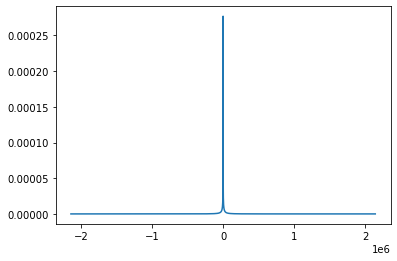

In [20]:
plt.plot(xs, prior_vals)
plt.title("")
#plt.xlim([-1000,1000])


In [21]:
#sum(prior_vals) * 200

In [22]:
np.trapz(prior_vals, xs) 


0.996091458032099

In [8]:
k = 6
eng.testIntegrals(0.1, 1.4, float(10**k), nargout=1)

3.917253393090709e-20

In [9]:
type(10**7)

int

eng.testIntegrals(0.2, 1.4, 10e6, nargout=1) 

In [17]:
def compute_prior_cdf(r, eta, n_samples = 1000, tail_bound = 0.05, n_tail = 5, scale = 1, scipy_int=True):

    '''
    Returns PPoly-type function that approximates the prior CDF of the signal x
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_cdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_cdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby <= 99:
        n_tail = 0
        print("No Tail")
    
    print(cheby)
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = prior_pdf[j] = eng.testIntegrals(float(r), float(eta), x, nargout=1)

    prior_cdf = np.zeros_like(prior_pdf)
    for i in range(len(xs) - 1):
        prior_cdf[i] = np.trapz(prior_pdf[:i+1], xs[:i+1]) 
    prior_cdf = np.append(prior_cdf[:-1], 1)
    poly = interpolate.CubicSpline(x = xs, y = prior_cdf)
    return poly

In [23]:
pcdf = compute_prior_cdf(r = .2, eta= 1.4, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)

23357984.570025407


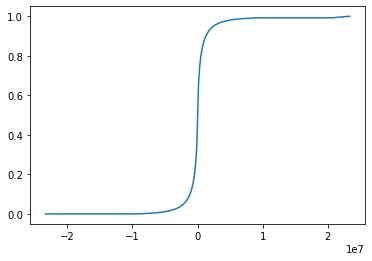

In [24]:
plt.plot(xs, pcdf(xs))

In [51]:
pcdf(22)

array(0.75479706)

In [42]:
pcdf(-40)

array(0.00012358)